## Loading Libraries

In [1]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
import skimage as ski
from matplotlib import animation            # Module to plot animations

## Load image and select frame

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ski_io
from cellpose import models
import pandas as pd

# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)



## Analyzing cell size and cytoplasm using CELLPOSE

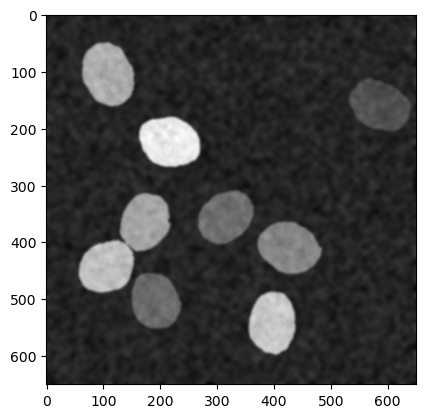

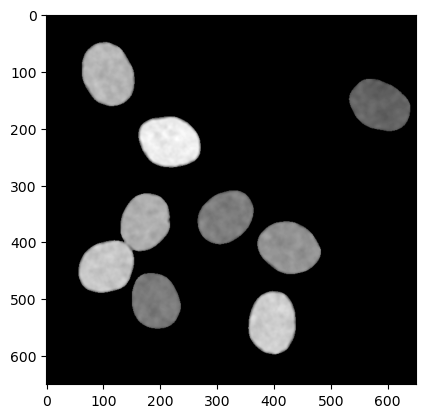

In [3]:
selected_frame = 4
selected_color_channel = 1

# Select the appropriate frame and color channel
img_to_analyze = img[selected_frame, :, :, selected_color_channel] #selecting the channel that will analyze cytoplasm

# Display the image to analyze
plt.imshow(img_to_analyze, cmap='gray')
plt.show()

# Initialize Cellpose model for cytoplasm detection
model_cyto = models.Cellpose(gpu=False, model_type='cyto')

# Run Cellpose for cytoplasm detection
masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0]) 

# Apply the cytoplasm mask to the original image
img_bin_cyto = img_to_analyze * (masks_cyto > 0.5) #mask that will help binarize image, if it is higher than 0.5 it will accept it into the area, which will account for one cell

# Plotting the masked cytoplasm image
plt.imshow(img_bin_cyto, cmap='gray') 
plt.show()

# Prepare data for the cytoplasm DataFrame
data_cyto = []
for cell_id in np.unique(masks_cyto):
    if cell_id == 0:
        continue  # skip the background

    mask = masks_cyto == cell_id
    sum_pix_intensity = img_to_analyze[mask].sum() #function that will add every pixel intensity for the cell/cytoplasm 
    cell_sizes = np.sum(mask)

    data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes]) #saves the data into a data frame that contains the cell number, intensity of the cell, and the size of each cell

df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])  


## Analyzing nuclei size using CELLPOSE

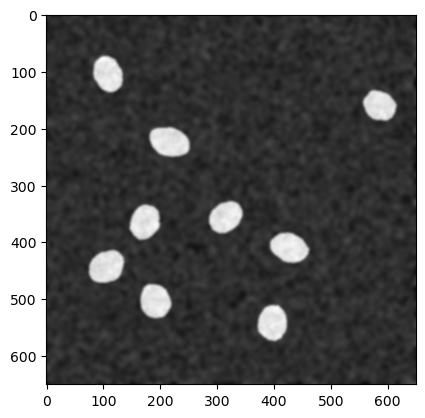

In [4]:
selected_frame = 4
selected_color_channel = 0

# Select the appropriate frame and color channel
img_to_analyze = img[selected_frame, :, :, selected_color_channel] #selecting the channel for nucleus analysis

# Display the image to analyze
plt.imshow(img_to_analyze, cmap='gray')
plt.show()

# Initialize Cellpose model for nuclei detection
model_nuclei = models.Cellpose(gpu=False, model_type='nuclei') 

# Run Cellpose for nuclei detection
masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0]) #runs cellpose, to the nuclei (nucleus) variable

# Prepare data for the nuclei DataFrame
data_nuclei = []
for cell_id in np.unique(masks_nuclei): #selects nucleus from cell
    if cell_id == 0:
        continue  # skip the background

    mask = masks_nuclei == cell_id #assigns the nucleus to the cell
    nucleus_sizes = np.sum(mask)  #gets the size of the nucleus by looking at the mask area
    sum_pix_intensity = img_to_analyze[mask].sum()

    data_nuclei.append([selected_frame, cell_id, nucleus_sizes,sum_pix_intensity ])
df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes','sum_pix_intensity_nuclei'])


## Counting Protein Concentration (sum_pix_intensity_cyto-sum_pix_intensity_nuclei)/(cell_size-nucleus_size)

In [5]:

# Display the DataFrames
print("Cytoplasm DataFrame:")
print(df_cyto)

print("\nNuclei DataFrame:")
print(df_nuclei)

# Merge the Cytoplasm and Nuclei DataFrames based on the 'cell' column
df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
df_merged['time'] = df_merged['time_x']
df_merged = df_merged.drop(columns=['time_x', 'time_y'])
df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
df_merged['protein concentrations (AU)'] = (df_merged['sum_pix_intensity_cyto']-df_merged['sum_pix_intensity_nuclei']) / (df_merged['cell sizes']-df_merged['nucleus sizes']) #intensity/area of the substraction of the nucleus to the cytoplasm (to determine Protein concentration while getting rid of redundancy)
df_merged = df_merged.drop(columns=['sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei'])

# Display the merged DataFrame
print("Merged DataFrame:")
print(df_merged)


Cytoplasm DataFrame:
   time  cell_ID  sum_pix_intensity_cyto  cell sizes
0     4        1                  940770        8167
1     4        2                  479678        7425
2     4        3                 1162659        7859
3     4        4                  574549        7092
4     4        5                  776694        6984
5     4        6                  736931        7816
6     4        7                  908015        7237
7     4        8                  534028        6718
8     4        9                  960991        7461

Nuclei DataFrame:
   time  cell_ID  nucleus sizes  sum_pix_intensity_nuclei
0     4        1           2558                    420725
1     4        2           2368                    384264
2     4        3           2951                    480327
3     4        4           2495                    408649
4     4        5           2526                    412565
5     4        6           2715                    446752
6     4        7        

mRNA

NameError: name 'difference_of_gaussians' is not defined

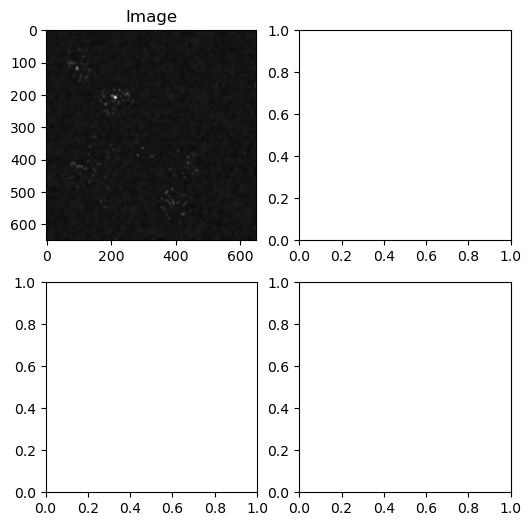

In [6]:
# Selecting the color channel with RNA spots
selected_frame = 2
selected_color_channel = 2
# Select the appropriate frame and color channel
img_to_analyze = img[selected_frame,:,:,selected_color_channel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_to_analyze,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_to_analyze,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

# print intensity range
plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

In [ ]:
# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_to_analyze,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
threshold = 0.05
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()